In [420]:
#meaningless edit for practice
import mdtraj as md
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import itertools    
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pandas as pd
from itertools import product
from numpy import random 
import itertools


In [421]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
sns.set_style("whitegrid")

In [423]:
def calc_SA(trj,helix,start,stop):
 RMS_start=start
 RMS_stop=stop
 RMS=[]
 for i in range(RMS_start,RMS_stop):
    sel=helix.topology.select("residue %s to %s and name CA" % (i,i+6))
    rmsd = md.rmsd(trj,helix,atom_indices=sel)
    RMS.append(rmsd)
 RMS=np.asarray(RMS)
 Sa_sum=np.zeros((trj.n_frames))
 Sa=(1.0-(RMS/0.08)**8)/(1-(RMS/0.08)**12)
 return Sa


def calc_Rg(trj):
 mass=[]
 for at in trj.topology.atoms:
    mass.append(at.element.mass)
 mass_CA = len(mass)*[0.0]
 for i in trj.topology.select("name CA"): mass_CA[i]=1.0
 rg_CA=md.compute_rg(trj, masses=np.array(mass_CA))
 return rg_CA

def free_energy(a,b,T,y0,ymax,x0,xmax):
  free_energy,xedges,yedges=np.histogram2d(a,b,30,[[y0,ymax],[x0,xmax]],normed=True,weights=None)
  free_energy=np.log(np.flipud(free_energy)+.000001)
  free_energy=-(0.001987*T)*free_energy
  return free_energy,xedges,yedges

def free_energy_1D_noscale(a,T,x0,xmax,bins):
  free_energy,xedges=np.histogram(a,bins=bins,range=[x0,xmax],density=True,weights=None)
  free_energy=np.log(free_energy+.000001)
  free_energy=-(0.001987*T)*free_energy
  xcenters= xedges[:-1] + np.diff(xedges)/2
  return free_energy,xcenters

def free_energy_1D(a,T,x0,xmax,bins):
  free_energy,xedges=np.histogram(a,bins=bins,range=[x0,xmax],density=True,weights=None)
  max=np.max(free_energy)  
  free_energy=np.log(free_energy+.0000001)
  free_energy=-(0.001987*T)*(free_energy-np.log(max+.0000001))
  xcenters= xedges[:-1] + np.diff(xedges)/2
  return free_energy,xcenters

def alphabeta_rmsd(phi,psi,phi_ref,psi_ref):
 alphabetarmsd=np.sum(0.5*(1+np.cos(psi-psi_ref)),axis=1)+np.sum(0.5*(1+np.cos(phi-phi_ref)),axis=1)
 return alphabetarmsd 

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 SE_H=np.zeros((len(dssp[0]),2))

 for i in range(0,len(dssp[0])): 
     data=dsspH[:,i].astype(float) 
     if(np.mean(data)>0):
      SE_H[i]=[np.mean(data),(block(data))**.5] 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 SE_E=np.zeros((len(dssp[0]),2))

 for i in range(0,len(dssp[0])):
     data=dsspE[:,i].astype(float)
     if(np.mean(data)>0):
      SE_E[i]=[np.mean(data),(block(data))**.5]
 return SE_H, SE_E


def calc_phipsi(trj):
 indices_phi, phis = md.compute_phi(trj)
 indices_psi, psis = md.compute_psi(trj)
 phi_label=[]
 for i_phi in range(0, indices_phi.shape[0]):
      resindex=trj.topology.atom(indices_phi[i_phi][2]).residue.resSeq
      phi_label.append(resindex)
 phi_label=np.array(phi_label)
 #print(phi_label)
 psi_label=[]
 for i_psi in range(0, indices_psi.shape[0]):
      resindex=trj.topology.atom(indices_psi[i_psi][2]).residue.resSeq
      psi_label.append(resindex)
 psi_label=np.array(psi_label)
 #print(psi_label)
 phipsi=[]
 for i in range(0,len(phi_label)-1):
  current_phipsi=np.column_stack((phis[:,i+1],psis[:,i]))
  phipsi.append(current_phipsi)
 phipsi_array=np.array(phipsi)
 return(phipsi_array,psi_label,phi_label)

def remove_adjacent(seq): # works on any sequence, not just on numbers
  i = 1
  n = len(seq)
  while i < n: # avoid calling len(seq) each time around
    if seq[i] == seq[i-1]:
      del seq[i]
      # value returned by seq.pop(i) is ignored; slower than del seq[i]
      n -= 1
    else:
      i += 1
  #### return seq #### don't do this
  # function acts in situ; should follow convention and return None


In [424]:
def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
    #    print("Warning: Data size = %g, is not a power of 2." % floor(2**d))
    #    print("Truncating data to %g." % 2**floor(d) )
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances 
    # for each blocking transformation
    for i in arange(0,d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum( (x[0:(n-1)]-mu)*(x[1:n]-mu) )
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])

    # generate the test observator M_k from the theorem
    M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]

    # we need a list of magic numbers
    q =array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0,d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))



In [425]:
#pdb=sys.argv[1]
#trajectory=sys.argv[2]
#helixpdb=sys.argv[3]
#outdir=sys.argv[3]
#trajdir='/Users/paulrobustelli/Desktop/drkN_reweight/a99SBdisp'
outdir='/Users/tommysisk/projects/msms/IDP_MSM/analysis'
if not os.path.exists(outdir):
    os.makedirs(outdir)    
pdb='/Users/tommysisk/projects/msms/IDP_MSM/Reference_Structures/Ntail.XD.pdb'
helixpdb='/Users/tommysisk/projects/msms/IDP_MSM/Reference_Structures/Ntail.helix.pdb'
trajectory='/Users/tommysisk/Trajectories/Ntail.XD.binding.400k.dcd'

print("outdir",outdir)
print("pdb",pdb)
print("helixpdb",helixpdb)
print("trajectory",trajectory)

outdir /Users/tommysisk/projects/msms/IDP_MSM/analysis
pdb /Users/tommysisk/projects/msms/IDP_MSM/Reference_Structures/Ntail.XD.pdb
helixpdb /Users/tommysisk/projects/msms/IDP_MSM/Reference_Structures/Ntail.helix.pdb
trajectory /Users/tommysisk/Trajectories/Ntail.XD.binding.400k.dcd


In [490]:
trj = md.load(trajectory, top=pdb,stride=100)
trj.center_coordinates()
top = trj.topology
native_PDB = md.load(pdb)
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames
trj

<mdtraj.Trajectory with 9981 frames, 1181 atoms, 186 residues, and unitcells at 0x7fc902686f98>

In [427]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
prot_top=top.subset(top.select('protein and name CA'))
prot_res=[]
for res in prot_top.residues: prot_res.append(res.resSeq)
prot_resname=(' %s' % [residue.name for residue in prot_top.residues])
residues=len(set(prot_res))

#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)


#We use prot_res for our residue indices
print("Protein Residues:",prot_res)
print("Protein Residue Names:",prot_resname)

frames=trj.n_frames
half=int(np.floor(frames/2))


** SYSTEM INFO **

Number of atoms: 1181

Number of residues: 68

Number of protein residues: 49

Number of frames: 9981

Starting frame: 0

Last frame: 9981

sequence:  [GLY458, ALA459, SER460, ARG461, SER462, VAL463, ILE464, ARG465, SER466, ILE467, ILE468, LYS469, SER470, SER471, ARG472, LEU473, GLU474, GLU475, ASP476, ARG477, LYS478, ARG479, TYR480, LEU481, MET482, THR483, LEU484, LEU485, ASP486, ASP487, ILE488, LYS489, GLY490, ALA491, ASN492, ASP493, LEU494, ALA495, LYS496, PHE497, HIS498, GLN499, MET500, LEU501, MET502, LYS503, ILE504, ILE505, MET506, GLY458, ALA459, SER460, ARG461, SER462, VAL463, ILE464, ARG465, SER466, ILE467, ILE468, LYS469, SER470, SER471, ARG472, LEU473, GLU474, GLU475, ASP476, ARG477, LYS478, ARG479, TYR480, LEU481, MET482, THR483, LEU484, LEU485, ASP486, ASP487, ILE488, LYS489, GLY490, ALA491, ASN492, ASP493, LEU494, ALA495, LYS496, PHE497, HIS498, GLN499, MET500, LEU501, MET502, LYS503, ILE504, ILE505, MET506, GLY484, SER485, GLN486, ASP487, SER488, ARG48

In [601]:
##finding resid values corresponding to Ntail-amore
top.select('chainid 1 and name CA') == top.select('protein and resid 98 to 118 and name CA')
N = top.select('chainid 1 and name CA')
[top.atom(i).residue for i in N]


[GLY484,
 SER485,
 GLN486,
 ASP487,
 SER488,
 ARG489,
 ARG490,
 SER491,
 ALA492,
 ASP493,
 ALA494,
 LEU495,
 LEU496,
 ARG497,
 LEU498,
 GLN499,
 ALA500,
 MET501,
 ALA502,
 GLY503,
 ILE504]

In [661]:
len(trj)

9981

In [603]:
##finding the resid values corresponding to XD domain
top.select('chainid 0 and name CA') == top.select('resid 0 to 48 and name CA')
X = top.select('chainid 0 and name CA')
[top.atom(i).residue for i in X]


[GLY458,
 ALA459,
 SER460,
 ARG461,
 SER462,
 VAL463,
 ILE464,
 ARG465,
 SER466,
 ILE467,
 ILE468,
 LYS469,
 SER470,
 SER471,
 ARG472,
 LEU473,
 GLU474,
 GLU475,
 ASP476,
 ARG477,
 LYS478,
 ARG479,
 TYR480,
 LEU481,
 MET482,
 THR483,
 LEU484,
 LEU485,
 ASP486,
 ASP487,
 ILE488,
 LYS489,
 GLY490,
 ALA491,
 ASN492,
 ASP493,
 LEU494,
 ALA495,
 LYS496,
 PHE497,
 HIS498,
 GLN499,
 MET500,
 LEU501,
 MET502,
 LYS503,
 ILE504,
 ILE505,
 MET506]

In [748]:
def Pauls_Paper_Q_atomistic(t,native):
    BETA_CONST = 10
    NATIVE_CUTOFF = 0.5
    """first version shows how to compute the distances between all atoms not on the same residue"""
    #heavy = top.select("symbol != H")
    #heavy_pairs = np.array([(i,j) for (i,j) in combinations(heavy,2)
                        #if abs(top.atom(i).residue.index - top.atom(j).residue.index) > 0])
    """second version shows how to compute the distances between all atoms pairs of two different chains"""
    heavy_atoms_XD = top.select("chainid 0 and not type H")
    heavy_atoms_Ntail = top.select("chainid 1 and not type H")
    heavy_pairs = list(product(heavy_atoms_Ntail,heavy_atoms_XD))
    heavy_pairs = np.array([list(i) for i in heavy_pairs])
    heavy_pairs_distances = md.compute_distances(native, heavy_pairs)[0]
    native_contacts = heavy_pairs[heavy_pairs_distances < NATIVE_CUTOFF]
    residue_contact_pairs = [(top.atom(x), top.atom(y)) for (x,y) in native_contacts.tolist()]
    print("The number of native contacts is", len(native_contacts))
    TF_int = (md.compute_distances(t,native_contacts) < NATIVE_CUTOFF).astype(int).T
    df = pd.DataFrame(data = TF_int, index = residue_contact_pairs)
    print(df)
    r = md.compute_distances(t, native_contacts)
    Q = np.sum((1.0 / (1 + np.exp(BETA_CONST * (r - NATIVE_CUTOFF)))), axis = 1)/len(native_contacts)
    plt.plot(Q)
    plt.show
    return Q

In [749]:
def Pauls_Paper_Q_residues_norm_and_frequency(t,native):
    
    """get all 'general' intermolecular native contacts within a certain distance in the native structure/PDB, 
    identify the names of the residue pairs, construct initial dataframe showing if pairs are in each frame. 
    Compute 'GQ', which is the unrefined distrbution of Q throughout the simulation"""
    
    BETA_CONST = 10
    NATIVE_CUTOFF = 0.5
    CONTACT_FREQ = .60
    RMSD_DISTANCE_FROM_NATIVE = 1
    Ntail_resID = np.arange(98, 119)
    XD_resID = np.arange(0,49)
    pairsl = list(product(Ntail_resID, XD_resID ))
    pairs = np.array([list(i) for i in pairs_total])
    pairs_distance_native = md.compute_contacts(native, pairs)[0][0]
    native_contact_pairs = pairs[pairs_distance_native < NATIVE_CUTOFF]
    native_contact_pairs_names = [(top.residue(x), top.residue(y)) for (x,y) in native_contact_pairs.tolist()]
    TF_int = (md.compute_contacts(t,native_contacts)[0] < NATIVE_CUTOFF).astype(int).T
    TFint_resid_pairs = np.hstack((native_contact_pairs,TF_int) )
    df = pd.DataFrame(data = TFint_resid_pairs, index = native_contact_pairs_names)
    print("The number of general native contacts is", len(native_contact_pairs))
    print(df)
    r = md.compute_contacts(trj, native_contacts)[0]
    QG = np.sum((1.0 / (1 + np.exp(BETA_CONST * (r - NATIVE_CUTOFF)))), axis = 1)/len(native_contact_pairs)
    
    """apply frequency constraint to general native contacts; contacts must be in CONTACT_FREQ% of all frames to 
    remain in the native contacts array
    have QG(general) and QR(reduced)"""
    
    df_reduced = df[df.iloc[:,2:].sum(axis = 1)/len(t) > CONTACT_FREQ]
    reduced_native_contacts = [*zip(df_reduced.iloc[:, 0], df_reduced.iloc[:,1])]
    reduced_native_contacts = np.array([list(i) for i in reduced_native_contacts])
    print('The number of frequency reduced native contacts is', len(reduced_native_contacts))
    print(df_reduced)
    rr = md.compute_contacts(t,reduced_native_contacts)[0]
    QR = np.sum((1.0 / (1 + np.exp(BETA_CONST * (rr - NATIVE_CUTOFF)))), axis = 1)/len(reduced_native_contacts)
    fig, (pQG, pQR) = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
    pQG.set_title("QG")
    pQR.set_title("QR")
    pQG.plot(QG)
    pQR.plot(QR)
    
    plt.show()
    return QG, df, QR, df_reduced

In [750]:
def Pauls_Paper_Q_frequency_in_folded_states(t,native):
    BETA_CONST = 10
    NATIVE_CUTOFF = 0.5
    CONTACT_FREQ = .85
    RMSD_DISTANCE_FROM_NATIVE = .99999
    Ntail_resID = np.arange(98, 119)
    XD_resID = np.arange(0,49)
    pairsl = list(product(Ntail_resID, XD_resID))
    pairs = np.array([list(i) for i in pairs_total])
    pairs_distance_native = md.compute_contacts(native, pairs)[0][0]
    native_contact_pairs = pairs[pairs_distance_native < NATIVE_CUTOFF]
    native_contact_pairs_names = [(top.residue(x), top.residue(y)) for (x,y) in native_contact_pairs.tolist()]
    folded_frames_t = t[md.rmsd(t, native) < RMSD_DISTANCE_FROM_NATIVE]
    TF_int = (md.compute_contacts(folded_frames_t,native_contacts)[0] < NATIVE_CUTOFF).astype(int).T
    TFint_resid_pairs = np.hstack((native_contact_pairs,TF_int) )
    df = pd.DataFrame(data = TFint_resid_pairs, index = native_contact_pairs_names)
    df_reduced = df[df.iloc[:, 2:].sum(axis = 1)/len(folded_frames_t) > CONTACT_FREQ]
    reduced_native_contacts = [*zip(df_reduced.iloc[:, 0], df_reduced.iloc[:,1])]
    reduced_native_contacts = np.array([list(i) for i in reduced_native_contacts])
    print('The number of frequency reduced native contacts is', len(reduced_native_contacts))
    rr = md.compute_contacts(t,reduced_native_contacts)[0]
    QFFR = np.sum((1.0 / (1 + np.exp(BETA_CONST * (rr - NATIVE_CUTOFF)))), axis = 1)/len(reduced_native_contacts)
    plt.plot(QFFR)
    return QFFR, df, df_reduced

The number of frequency reduced native contacts is 23


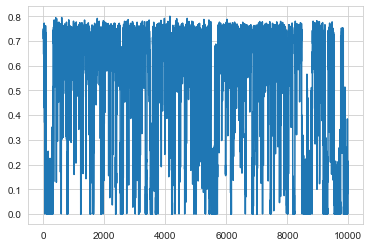

In [706]:
QFFR, df, df_reduced = Pauls_Paper_Q_frequency_in_folded_states(trj, native_PDB)

The number of general native contacts is 38
                  0     1     2     3     4     5     6     7     8     9     \
(ARG477, MET501)    19   115     0     0     1     1     1     0     1     1   
(TYR480, ARG497)    22   111     1     1     1     1     1     1     1     1   
(TYR480, MET501)    22   115     1     1     1     1     1     1     1     1   
(LEU481, LEU498)    23   112     1     1     1     1     1     1     1     1   
(LEU481, MET501)    23   115     1     0     1     1     1     1     1     1   
(LEU484, ALA494)    26   108     1     1     1     1     1     1     1     1   
(LEU484, ARG497)    26   111     1     1     1     1     1     1     1     1   
(LEU484, LEU498)    26   112     1     1     1     1     1     1     1     1   
(LEU484, MET501)    26   115     0     0     0     0     1     0     0     0   
(ASP486, ARG490)    28   104     0     0     1     0     0     0     0     0   
(ASP487, ASP487)    29   101     1     0     0     1     0     0     0     0

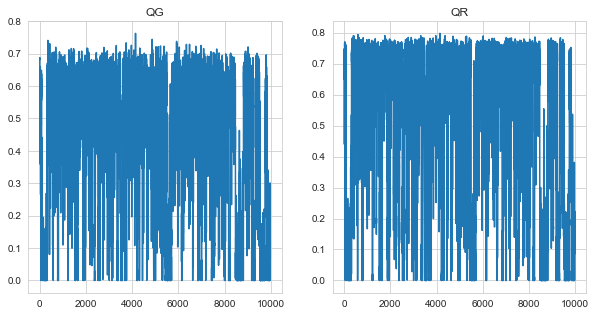

In [639]:
QG, df, QR, df_reduced = Pauls_Paper_Q_residues(trj,native_PDB)

The number of native contacts is 320
                         0     1     2     3     4     5     6     7     8     \
(ARG477-CG, MET501-CE)      0     0     1     1     1     0     1     0     1   
(TYR480-CG, MET501-SD)      0     0     0     0     1     0     1     1     1   
(TYR480-CD2, MET501-SD)     0     0     0     1     0     0     1     1     1   
(TYR480-CD2, MET501-CE)     1     0     0     1     0     0     0     1     1   
(TYR480-CE2, MET501-CG)     0     0     0     0     0     0     1     0     0   
...                       ...   ...   ...   ...   ...   ...   ...   ...   ...   
(ILE504-CD1, MET501-O)      0     0     1     1     1     0     1     0     1   
(ILE504-CD1, MET501-CB)     1     0     0     1     0     0     0     0     1   
(ILE504-CD1, MET501-CE)     1     0     0     0     1     1     1     0     0   
(ILE504-CD1, ALA502-N)      1     0     1     1     1     0     1     0     1   
(ILE504-CD1, ALA502-CA)     1     0     1     1     1     0     1     1 

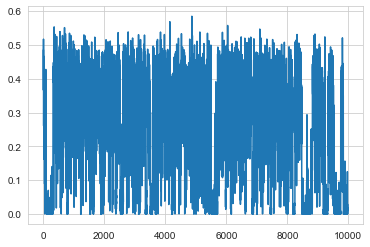

In [587]:
Q = Pauls_Paper_Q_atomistic(trj,native_PDB)


In [268]:
resID_XD = top.select("protein and resid 0 to 48")
resID_XD = [top.atom(i) for i in resID_XD]
print(resID_XD)

resID_NT = top.select("protein and resid 98 to 118")
resID_NT = [top.atom(i) for i in resID_NT]
print(resID_NT)

#XD Heavy Atoms
resID_test = top.select("chainid 0 and not type H")

for i in resID_test:
    print(top.atom(i),top.atom(i).residue.resSeq)

#Ntail Heavy Atoms
resID_test = top.select("chainid 1 and not type H")

for i in resID_test:
    print(top.atom(i),top.atom(i).residue.resSeq)
  
#for res in top.chain(0).residues:
#    print("A",res,res.index,res.resSeq)

#for res in top.chain(1).residues:
#    print("B",res,res.index,res.resSeq)

#Heavy atoms XD resid 0 to 48 
#H atoms XD resid 49 to 97
#Heavy atoms Ntail 98 to 118
#H atoms Ntail 119 to 140

[GLY458-N, GLY458-CA, GLY458-C, GLY458-O, ALA459-N, ALA459-CA, ALA459-C, ALA459-O, ALA459-CB, SER460-N, SER460-CA, SER460-C, SER460-O, SER460-CB, SER460-OG, ARG461-N, ARG461-CA, ARG461-C, ARG461-O, ARG461-CB, ARG461-CG, ARG461-CD, ARG461-NE, ARG461-CZ, ARG461-NH1, ARG461-NH2, SER462-N, SER462-CA, SER462-C, SER462-O, SER462-CB, SER462-OG, VAL463-N, VAL463-CA, VAL463-C, VAL463-O, VAL463-CB, VAL463-CG1, VAL463-CG2, ILE464-N, ILE464-CA, ILE464-C, ILE464-O, ILE464-CB, ILE464-CG1, ILE464-CG2, ILE464-CD1, ARG465-N, ARG465-CA, ARG465-C, ARG465-O, ARG465-CB, ARG465-CG, ARG465-CD, ARG465-NE, ARG465-CZ, ARG465-NH1, ARG465-NH2, SER466-N, SER466-CA, SER466-C, SER466-O, SER466-CB, SER466-OG, ILE467-N, ILE467-CA, ILE467-C, ILE467-O, ILE467-CB, ILE467-CG1, ILE467-CG2, ILE467-CD1, ILE468-N, ILE468-CA, ILE468-C, ILE468-O, ILE468-CB, ILE468-CG1, ILE468-CG2, ILE468-CD1, LYS469-N, LYS469-CA, LYS469-C, LYS469-O, LYS469-CB, LYS469-CG, LYS469-CD, LYS469-CE, LYS469-NZ, SER470-N, SER470-CA, SER470-C, SER470-O, 

In [299]:
top_df,bonds = top.to_dataframe()
top_df

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,N,N,458,GLY,0,C1
1,2,CA,C,458,GLY,0,C1
2,3,C,C,458,GLY,0,C1
3,4,O,O,458,GLY,0,C1
4,5,N,N,459,ALA,0,C1
...,...,...,...,...,...,...,...
1176,1177,CL,Cl,15,CL,3,C1
1177,1178,CL,Cl,16,CL,3,C1
1178,1179,CL,Cl,17,CL,3,C1
1179,1180,CL,Cl,18,CL,3,C1


In [72]:
for i in trj.topology.select('residue 504'):
    print(i,trj.topology.atom(i))

371 ILE504-N
372 ILE504-CA
373 ILE504-C
374 ILE504-O
375 ILE504-CB
376 ILE504-CG1
377 ILE504-CG2
378 ILE504-CD1
790 ILE504-H
791 ILE504-HA
792 ILE504-HB
793 ILE504-HG13
794 ILE504-HG12
795 ILE504-HG21
796 ILE504-HG22
797 ILE504-HG23
798 ILE504-HD11
799 ILE504-HD12
800 ILE504-HD13
967 ILE504-N
968 ILE504-CA
969 ILE504-C
970 ILE504-O
971 ILE504-CB
972 ILE504-CG1
973 ILE504-CG2
974 ILE504-CD1
1121 ILE504-H
1122 ILE504-HA
1123 ILE504-HB
1124 ILE504-HG13
1125 ILE504-HG12
1126 ILE504-HG21
1127 ILE504-HG22
1128 ILE504-HG23
1129 ILE504-HD11
1130 ILE504-HD12
1131 ILE504-HD13
1132 ILE504-O


the cell below kills my kernel everytime

In [ ]:
trjBB = md.load(trajectory, top=pdb,stride=10)
trjBB.restrict_atoms(top.select('protein and backbone and not index 310 '))
trjBB.center_coordinates()


dssp=md.compute_dssp(trjBB, simplified=True)
np.savetxt(outdir+"/dssp.out",dssp,fmt='%s')
H1_H,H1_E=dssp_convert(dssp)

dsspH=np.copy(dssp)
dsspH[dsspH=='H']=1                                                                                      
dsspH[dsspH=='E']=0                                                                                      
dsspH[dsspH=='C']=0                                                                                      
dsspH[dsspH=='NA']=0 
dsspH=dsspH.astype(int)
np.savetxt(outdir+"/dssp.H.dat",dsspH,fmt='%i')
np.savetxt(outdir+"/Hprop.dat",np.column_stack((prot_res,H1_H)),fmt="%.3f")

dsspE=np.copy(dssp)
dsspE[dsspE=='H']=0
dsspE[dsspE=='E']=1
dsspE[dsspE=='C']=0
dsspE[dsspE=='NA']=0
dsspE=dsspE.astype(int)
np.savetxt(outdir+"/dssp.E.dat",dsspE,fmt='%i')
np.savetxt(outdir+"/Eprop.dat",np.column_stack((prot_res,H1_E)),fmt="%.3f")


In [ ]:
plt.clf()
plt.errorbar(prot_res,H1_H[:,0],yerr=H1_H[:,1], capsize=5,label='Helix')
plt.errorbar(prot_res,H1_E[:,0],yerr=H1_E[:,1], capsize=5,label='Sheet')
plt.ylim(0,1.0)
plt.legend()
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.savefig(outdir+'/SS.png')

In [ ]:
#https://www.plumed.org/doc-v2.6/user-doc/html/_a_l_p_h_a_b_e_t_a.html
#Compute Phi and Psi
#phipsi_array,psi_labels,phi_labels=calc_phipsi(trj)
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
np.savetxt(outdir+"/phis.dat",phis,fmt="%.3f")
np.savetxt(outdir+"/psis.dat",psis,fmt="%.3f")

Phi_all=phis
Psi_all=psis
alphabeta_alpharight=alphabeta_rmsd(Phi_all,Psi_all,-1.05,-0.79)
alphabeta_betasheet=alphabeta_rmsd(Phi_all,Psi_all,2.36,-2.36)
alphabeta_ppII=alphabeta_rmsd(Phi_all,Psi_all,-1.31,2.71)
np.savetxt(outdir+"/alphabeta_alpharight.dat",alphabeta_alpharight,fmt="%.3f")
np.savetxt(outdir+"/alphabeta_betasheet.dat",alphabeta_betasheet,fmt="%.3f")
np.savetxt(outdir+"/alphabeta_ppII.dat",alphabeta_ppII,fmt="%.3f")

plt.clf()
sns.kdeplot(data=alphabeta_alpharight,label='Alpha Helix')
sns.kdeplot(data=alphabeta_betasheet,label='Beta Sheet')
sns.kdeplot(data=alphabeta_ppII,label='ppII')
plt.tick_params(labelsize=18)
plt.xlabel('Alphabeta RMSD',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.xlim(0,40)
plt.ylim(0,0.40)
plt.legend(loc='upper right')
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.savefig(outdir+'/Alphabeta.png')



CA Radius of Gyration All: 1.788 +_ 0.010


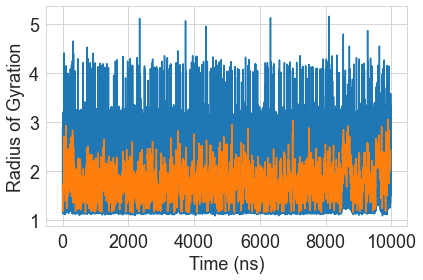

In [15]:
rg=calc_Rg(trj)
np.savetxt(outdir+"/Rg.dat",rg,fmt="%.3f")
print("CA Radius of Gyration All:%6.3lf"%np.average(rg),"+_%6.3lf"%block(rg)**.5)
np.savetxt(outdir+"/Rg.ave.dat",np.column_stack((np.average(rg),block(rg)**.5)),fmt="%.3f")

N=10
plt.clf()
plt.plot(rg)
plt.plot(np.convolve(rg,np.ones(N)/N,mode='valid'))
plt.xlabel('Time (ns)', size=18)
plt.ylabel('Radius of Gyration', size=18)
plt.tick_params(labelsize=18)

plt.tight_layout()
plt.savefig(outdir+'/Rg.png')

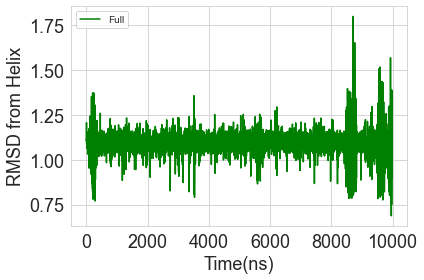

In [16]:
#helixpdb='/Users/paulrobustelli/Desktop/drkN_reweight/a99SBdisp/drkN.helix.pdb'
helix = md.load_pdb(helixpdb)

backbone_helix=helix.topology.select("name CA")
#backbone_helix1=helix.topology.select("name CA and residue 10 to 30")
#backbone_helix2=helix.topology.select("name CA and residue 30 to 40")
#backbone_helix3=helix.topology.select("name CA and residue 50 to 60")

rmsdH = md.rmsd(trj,helix,atom_indices=backbone_helix)
#rmsdH1 = md.rmsd(trj,helix,atom_indices=backbone_helix1)
#rmsdH2 = md.rmsd(trj,helix,atom_indices=backbone_helix2)
#rmsdH3 = md.rmsd(trj,helix,atom_indices=backbone_helix3)

plt.clf()
N=1
plt.plot(np.convolve(rmsdH,np.ones(N)/N,mode='valid'),label='Full',c='g')
#plt.plot(np.convolve(rmsdH1,np.ones(N)/N,mode='valid'),label='H1',c='r')
#plt.plot(np.convolve(rmsdH2,np.ones(N)/N,mode='valid'),label='H2',c='b')
#plt.plot(np.convolve(rmsdH3,np.ones(N)/N,mode='valid'),label='H3',c='g')

plt.legend()
plt.xlabel('Time(ns)', size=18)
plt.ylabel('RMSD from Helix', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.savefig(outdir+'/Helix_RMSD.png')

In [326]:
tt = top.select('protein and resid 98 to 118 and name CA')
[top.atom(i).residue for i in tt]

[GLY484,
 SER485,
 GLN486,
 ASP487,
 SER488,
 ARG489,
 ARG490,
 SER491,
 ALA492,
 ASP493,
 ALA494,
 LEU495,
 LEU496,
 ARG497,
 LEU498,
 GLN499,
 ALA500,
 MET501,
 ALA502,
 GLY503,
 ILE504]

GLY1-CA
SER2-CA
GLN3-CA
ASP4-CA
SER5-CA
ARG6-CA
ARG7-CA
SER8-CA
ALA9-CA
ASP10-CA
ALA11-CA
LEU12-CA
LEU13-CA
ARG14-CA
LEU15-CA
GLN16-CA
ALA17-CA
MET18-CA
ALA19-CA
GLY20-CA
ILE21-CA
GLY484-CA
SER485-CA
GLN486-CA
ASP487-CA
SER488-CA
ARG489-CA
ARG490-CA
SER491-CA
ALA492-CA
ASP493-CA
ALA494-CA
LEU495-CA
LEU496-CA
ARG497-CA
LEU498-CA
GLN499-CA
ALA500-CA
MET501-CA
ALA502-CA
GLY503-CA
ILE504-CA


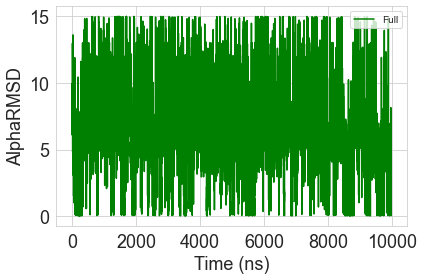

In [588]:
#https://www.plumed.org/doc-v2.6/user-doc/html/_a_l_p_h_a_r_m_s_d.html
#helixpdb='/Users/paulrobustelli/Desktop/drkN_reweight/a99SBdisp/drkN.helix.pdb'
helixBB = md.load_pdb(helixpdb)
trjBB = md.load(trajectory, top=pdb,stride=100)
#trajBB = trj

#Define the selection so that its only the CA atoms of Ntail
BB=trjBB.topology.select("protein and resid 98 to 118 and name CA")
HBB = helixBB.topology.select("name CA")
for i in HBB:
    print(helixBB.topology.atom(i))
    
for i in BB:
    print(trjBB.topology.atom(i))
#Iterate over residue names/ids to make sure BB and HBB correspond to the same residues

trjBB.restrict_atoms(BB)
helixBB.restrict_atoms(HBB)
trjBB.center_coordinates()
helixBB.center_coordinates()

#Check the indices you're iterating over
Sa= calc_SA(trjBB,helixBB,0,15)
Sa_total=np.sum(Sa, axis=0)
Sa_ave=np.average(Sa,axis=1)
np.savetxt(outdir+"/Sa.dat",Sa,fmt="%.3f")
np.savetxt(outdir+"/Sa.total.dat",Sa_total,fmt="%.3f")

#Sa_H1= calc_SA(trjBB, helixBB, 10, 30)
#Sa_total_H1=np.sum(Sa_H1, axis=0)
#Sa_ave_H1=np.average(Sa_H1,axis=1)
#np.savetxt(outdir+"/Sa.H1.dat",Sa_total_H1,fmt="%.3f")

#Sa_H2= calc_SA(trjBB, helixBB, 30, 40)
#Sa_total_H2=np.sum(Sa_H2, axis=0)
#Sa_ave_H2=np.average(Sa_H2,axis=1)
#np.savetxt(outdir+"/Sa.H2.dat",Sa_total_H2,fmt="%.3f")

plt.clf()
N=1
plt.plot(np.convolve(Sa_total,np.ones(N)/N,mode='valid'),label='Full',c='g')
#plt.plot(np.convolve(Sa_total_H1,np.ones(N)/N,mode='valid'),label='H1',c='r')
#plt.plot(np.convolve(Sa_total_H2,np.ones(N)/N,mode='valid'),label='H2',c='b')
plt.legend()
plt.xlabel('Time (ns)', size=18)
plt.ylabel('AlphaRMSD', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.savefig(outdir+'/AlphaRMSD.png')

In [ ]:

free_energy_1D(a,T,x0,xmax,bins):

In [590]:
Sa_total.shape

(9981,)

In [ ]:
#prot_res_renum[0:-1]
#res_renum=np.asarray(CAlabel[0:-1])+residue_offset
#print(residue_number)
plt.clf()
plt.plot(Sa_ave)
plt.xlabel('Residue', size=18)
plt.ylabel('AlphaRMSD', size=18)
plt.tick_params(labelsize=18)
plt.ylim(0,1.0)
plt.tight_layout()
plt.savefig(outdir+'/AlphaRMSD.byres.png')

In [ ]:
#contactmap_dir=outdir+'/contact_map'
#if not os.path.exists(contactmap_dir):
#    os.mkdir(contactmap_dir)

contact_maps = []
contact_distances = []
for i in range(0,21):
    contact_map = []
    contact_distance = []
    for j in range(0,21):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj,[[i,j]])
            array = np.asarray(dist[0]).astype(float)
            #np.savetxt('%s/%s.%s.dat'%(contactmap_dir,i,j),array,fmt="%.3f")
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 1.2, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

In [ ]:
sequence=[]
for residue in trjBB.topology.residues:
    sequence.append(residue)
len(sequence)

n=5
for i in range (0,len(sequence)): 
  if (i % n !=0):
   sequence[i]=''
contact_map = final_map

plt.clf()
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
im = sns.heatmap(contact_map, cmap = 'jet', ax = ax)
ax.grid(which='both', alpha=0.5)
plt.xticks(range(0,21), sequence, rotation=45, size=14)
plt.yticks(range(0,21),sequence, rotation=45, size=14)
cbar = im.collections[0].colorbar
# cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=22)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(outdir+'/contact_map.png')

In [ ]:
a,xedges,yedges=np.histogram2d(rg,Sa_total,35,[[0.5,1.5],[0,14.0]],normed=True,weights=None)
a=np.log(np.flipud(a)+.000001)
T=300
a=-(0.001987*T)*a

plt.clf()
fig=plt.figure(figsize=(8,6))
im=plt.imshow(a, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
cbar_ticks=[0,1,2,3]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Radius of Gryation",size=35,labelpad=15)
plt.xlabel("AlphaRMSD",size=35,labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.1,vmax=3.0)
plt.yticks(size='26')

plt.tight_layout()
plt.savefig(outdir+'/Rg_v_AlphaRMSD.png')

In [407]:
Salpha.shape

(15, 9981)

In [37]:
Sum_alpha = sum(Salpha, axis = 0)
Sum_alpha.shape

(9981,)

In [ ]:
free_energy(a,b,T,y0,ymax,x0,xmax)

In [42]:
print(Q.shape)
print(Sum_alpha.shape)

(9981,)
(9981,)


In [98]:
#make dataframe of calulations done on a perframe basis
data = np.stack((Q, Sum_alpha)).T
df = pd.DataFrame(data=data, columns = ["frac Q between heavy atoms of chain 0 and 1", "Sum_Alpha per frame, aMORE"])
df

,frac Q between heavy atoms of chain 0 and 1,"Sum_Alpha per frame, aMORE"
0,4.853002e-01,12.957582
1,3.661586e-01,11.173635
2,4.402086e-01,8.589869
3,5.170272e-01,11.763094
4,4.072023e-01,7.800382
...,...,...
9976,2.414963e-16,1.613707
9977,2.528927e-02,0.052564
9978,2.504154e-02,2.687311
9979,1.479539e-02,4.056242


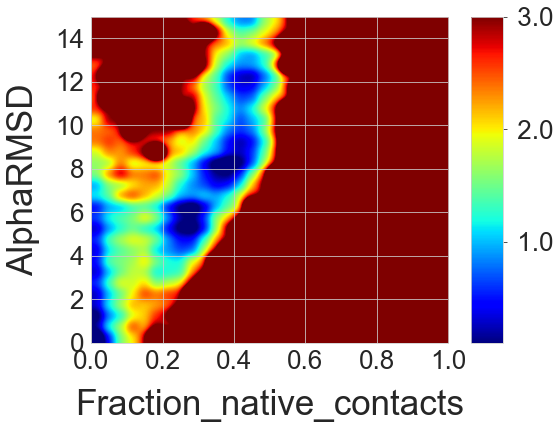

In [595]:
#plotting Sa vs. Q w/ free energy as coloring using ATOMISTIC DEFINITION OF Q
dG,xedges,yedges=free_energy(Sa_total,Q,300,0,15,0,1)
fig=plt.figure(figsize=(8,6))
im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
cbar_ticks=[0,1,2,3,4,5]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("AlphaRMSD",size=35,labelpad=15)
plt.xlabel("Fraction_native_contacts",size=35,labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='26')
plt.axes(cb.ax)
plt.clim(vmin=0.1,vmax=3.0)
plt.yticks(size='26')
np.savetxt(outdir+'Rg_v_Sa.dat',dG)
plt.savefig(outdir+'Rg_v_Sa.png')


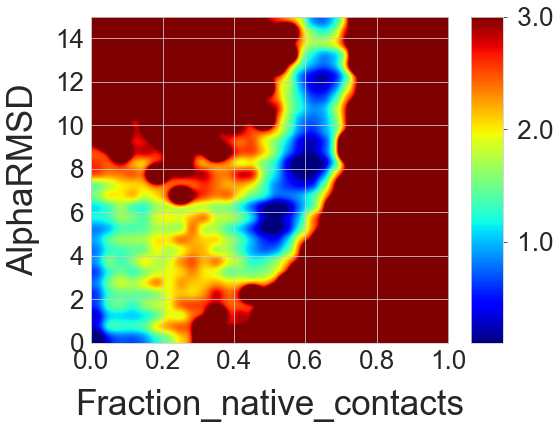

In [597]:
##S_alpha vs. QG (Q calculated for residues with compute contacts fxn, distance threshold = .5nm)
dG,xedges,yedges=free_energy(Sa_total,QG,300,0,15,0,1)
fig=plt.figure(figsize=(8,6))
im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
cbar_ticks=[0,1,2,3,4,5]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("AlphaRMSD",size=35,labelpad=15)
plt.xlabel("Fraction_native_contacts",size=35,labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='26')
plt.axes(cb.ax)
plt.clim(vmin=0.1,vmax=3.0)
plt.yticks(size='26')
np.savetxt(outdir+'Rg_v_Sa.dat',dG)
plt.savefig(outdir+'Rg_v_Sa.png')


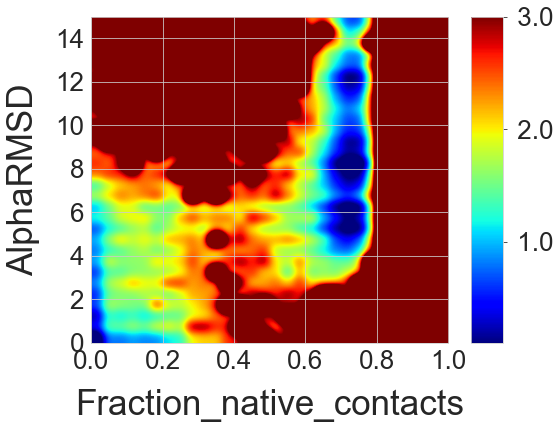

In [598]:
##S_alpha vs. QR (Q calculated for residues with compute contacts fxn, distance threshold = .5nm AND 
#only the native contacts that were present in atleast 60% of the frames were kept.

dG,xedges,yedges=free_energy(Sa_total,QR,300,0,15,0,1)
fig=plt.figure(figsize=(8,6))
im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
cbar_ticks=[0,1,2,3,4,5]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("AlphaRMSD",size=35,labelpad=15)
plt.xlabel("Fraction_native_contacts",size=35,labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='26')
plt.axes(cb.ax)
plt.clim(vmin=0.1,vmax=3.0)
plt.yticks(size='26')
np.savetxt(outdir+'Rg_v_Sa.dat',dG)
plt.savefig(outdir+'Rg_v_Sa.png')

In [609]:
##copy pauls list of native contacts
Ntail_Contact_L = [490, 491, 491, 494, 494, 494, 495, 495, 495, 495, 495, 497, 497, 498, 498, 498, 498, 498, 499, 501, 501, 502, 502, 502]
XD_Contact_L = [487, 487, 488, 484, 487, 488, 488, 496, 497, 500, 493, 480, 484, 484, 497, 500, 504, 481, 500, 481, 504, 504, 500, 503]


In [612]:
Ntail_Contact_L = [i-386 for i in Ntail_Contact_L]

In [613]:
XD_Contact_L = [i-458 for i in XD_Contact_L]

In [616]:
Pauls_native_contacts = [*zip(Ntail_Contact_L,XD_Contact_L )]

In [620]:
Pauls_native_contacts = np.array([list(i) for i in Pauls_native_contacts])

In [621]:
Pauls_native_contacts

array([[104,  29],
       [105,  29],
       [105,  30],
       [108,  26],
       [108,  29],
       [108,  30],
       [109,  30],
       [109,  38],
       [109,  39],
       [109,  42],
       [109,  35],
       [111,  22],
       [111,  26],
       [112,  26],
       [112,  39],
       [112,  42],
       [112,  46],
       [112,  23],
       [113,  42],
       [115,  23],
       [115,  46],
       [116,  46],
       [116,  42],
       [116,  45]])

In [710]:
native_contact_pairs_names = [(top.residue(x), top.residue(y)) for (x,y) in Pauls_native_contacts.tolist()]
native_contact_pairs_names

[(ARG490, ASP487),
 (SER491, ASP487),
 (SER491, ILE488),
 (ALA494, LEU484),
 (ALA494, ASP487),
 (ALA494, ILE488),
 (LEU495, ILE488),
 (LEU495, LYS496),
 (LEU495, PHE497),
 (LEU495, MET500),
 (LEU495, ASP493),
 (ARG497, TYR480),
 (ARG497, LEU484),
 (LEU498, LEU484),
 (LEU498, PHE497),
 (LEU498, MET500),
 (LEU498, ILE504),
 (LEU498, LEU481),
 (GLN499, MET500),
 (MET501, LEU481),
 (MET501, ILE504),
 (ALA502, ILE504),
 (ALA502, MET500),
 (ALA502, LYS503)]

In [695]:
top.residue(1).name

'ALA'

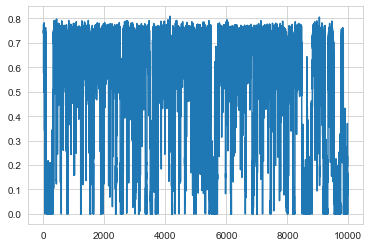

In [697]:
#Q calculation, with the definition of native contacts from paul's paper
BETA_CONST = 10, 
NATIVE_CUTOFF = .5
r = md.compute_contacts(trj,Pauls_native_contacts)[0]
Q_PAPER = np.sum((1.0 / (1 + np.exp(BETA_CONST * (r - NATIVE_CUTOFF)))), axis = 1)/len(native_contact_pairs_names)
plt.plot(Q_PAPER)

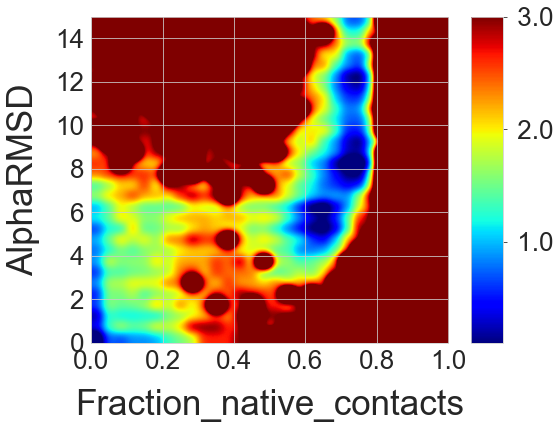

In [643]:
#alpha verses Q using Pauls native contacts
dG,xedges,yedges=free_energy(Sa_total,Q_PAPER,300,0,15,0,1)
fig=plt.figure(figsize=(8,6))
im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
cbar_ticks=[0,1,2,3,4,5]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("AlphaRMSD",size=35,labelpad=15)
plt.xlabel("Fraction_native_contacts",size=35,labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='26')
plt.axes(cb.ax)
plt.clim(vmin=0.1,vmax=3.0)
plt.yticks(size='26')
np.savetxt(outdir+'Rg_v_Sa.dat',dG)
plt.savefig(outdir+'Rg_v_Sa.png')

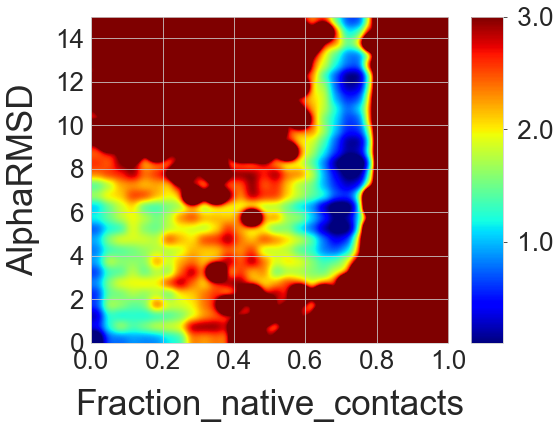

In [707]:
dG,xedges,yedges=free_energy(Sa_total,QFFR,300,0,15,0,1)
fig=plt.figure(figsize=(8,6))
im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
cbar_ticks=[0,1,2,3,4,5]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("AlphaRMSD",size=35,labelpad=15)
plt.xlabel("Fraction_native_contacts",size=35,labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='26')
plt.axes(cb.ax)
plt.clim(vmin=0.1,vmax=3.0)
plt.yticks(size='26')
np.savetxt(outdir+'Rg_v_Sa.dat',dG)
plt.savefig(outdir+'Rg_v_Sa.png')

In [636]:
##trying to reduce the number of frames to just the ones that are very close to the native state (PDB structure)
#shows that the smallest 1 sigfig measure of rmsd we can use before returning nothing is 9A or .9 nm.
folded_state_frames = trj[md.rmsd(trj, native_PDB) < 1]
folded_state_frames

<mdtraj.Trajectory with 80 frames, 1181 atoms, 186 residues, and unitcells at 0x7fc003ade128>

The number of general native contacts is 38
                  0    1   2   3   4   5   6   7   8   9   ...  72  73  74  \
(ARG477, MET501)  19  115   0   1   1   1   0   1   1   1  ...   1   1   1   
(TYR480, ARG497)  22  111   1   0   1   1   1   1   1   1  ...   1   1   0   
(TYR480, MET501)  22  115   1   1   1   1   1   1   1   1  ...   1   1   1   
(LEU481, LEU498)  23  112   1   1   1   1   1   1   1   1  ...   1   1   1   
(LEU481, MET501)  23  115   1   1   1   1   1   1   1   1  ...   1   1   1   
(LEU484, ALA494)  26  108   1   1   1   1   1   1   1   1  ...   1   1   1   
(LEU484, ARG497)  26  111   1   1   1   1   1   1   1   0  ...   1   1   1   
(LEU484, LEU498)  26  112   1   1   1   1   1   0   1   1  ...   1   1   1   
(LEU484, MET501)  26  115   0   1   1   0   0   0   0   0  ...   0   0   1   
(ASP486, ARG490)  28  104   0   0   0   0   0   0   0   0  ...   0   0   0   
(ASP487, ASP487)  29  101   1   0   0   1   0   0   0   1  ...   0   0   0   
(ASP487, ARG490)  29

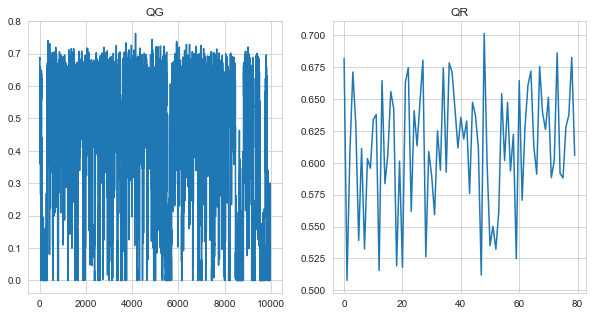

(array([0.682, 0.582, 0.643, ..., 0.130, 0.060, 0.071], dtype=float32),
                   0    1   2   3   4   5   6   7   8   9   ...  72  73  74  \
 (ARG477, MET501)  19  115   0   1   1   1   0   1   1   1  ...   1   1   1   
 (TYR480, ARG497)  22  111   1   0   1   1   1   1   1   1  ...   1   1   0   
 (TYR480, MET501)  22  115   1   1   1   1   1   1   1   1  ...   1   1   1   
 (LEU481, LEU498)  23  112   1   1   1   1   1   1   1   1  ...   1   1   1   
 (LEU481, MET501)  23  115   1   1   1   1   1   1   1   1  ...   1   1   1   
 (LEU484, ALA494)  26  108   1   1   1   1   1   1   1   1  ...   1   1   1   
 (LEU484, ARG497)  26  111   1   1   1   1   1   1   1   0  ...   1   1   1   
 (LEU484, LEU498)  26  112   1   1   1   1   1   0   1   1  ...   1   1   1   
 (LEU484, MET501)  26  115   0   1   1   0   0   0   0   0  ...   0   0   1   
 (ASP486, ARG490)  28  104   0   0   0   0   0   0   0   0  ...   0   0   0   
 (ASP487, ASP487)  29  101   1   0   0   1   0   0   0   1 

In [645]:
Pauls_Paper_Q_residues(folded_state_frames, native_PDB)

In [736]:
native_contact_pairs_names_paper = np.asarray(native_contact_pairs_names)
native_contact_pairs_names_paper.tolist()

[[ARG490, ASP487],
 [SER491, ASP487],
 [SER491, ILE488],
 [ALA494, LEU484],
 [ALA494, ASP487],
 [ALA494, ILE488],
 [LEU495, ILE488],
 [LEU495, LYS496],
 [LEU495, PHE497],
 [LEU495, MET500],
 [LEU495, ASP493],
 [ARG497, TYR480],
 [ARG497, LEU484],
 [LEU498, LEU484],
 [LEU498, PHE497],
 [LEU498, MET500],
 [LEU498, ILE504],
 [LEU498, LEU481],
 [GLN499, MET500],
 [MET501, LEU481],
 [MET501, ILE504],
 [ALA502, ILE504],
 [ALA502, MET500],
 [ALA502, LYS503]]

In [743]:
mine = np.asarray(df_reduced.index)

In [746]:
mine

array([(ARG477, MET501), (TYR480, ARG497), (TYR480, MET501),
       (LEU481, LEU498), (LEU481, MET501), (LEU484, ALA494),
       (LEU484, ARG497), (LEU484, LEU498), (ASP487, ALA494),
       (ILE488, SER491), (ILE488, ALA494), (ILE488, LEU495),
       (ASP493, LEU495), (LYS496, LEU495), (PHE497, LEU495),
       (PHE497, LEU498), (MET500, LEU495), (MET500, LEU498),
       (MET500, GLN499), (MET500, ALA502), (ILE504, LEU498),
       (ILE504, MET501), (ILE504, ALA502)], dtype=object)

In [745]:
native_contact_pairs_names_paper

array([[ARG490, ASP487],
       [SER491, ASP487],
       [SER491, ILE488],
       [ALA494, LEU484],
       [ALA494, ASP487],
       [ALA494, ILE488],
       [LEU495, ILE488],
       [LEU495, LYS496],
       [LEU495, PHE497],
       [LEU495, MET500],
       [LEU495, ASP493],
       [ARG497, TYR480],
       [ARG497, LEU484],
       [LEU498, LEU484],
       [LEU498, PHE497],
       [LEU498, MET500],
       [LEU498, ILE504],
       [LEU498, LEU481],
       [GLN499, MET500],
       [MET501, LEU481],
       [MET501, ILE504],
       [ALA502, ILE504],
       [ALA502, MET500],
       [ALA502, LYS503]], dtype=object)